## Importing libraries

In [39]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
import math
import matplotlib.pyplot as plt
from PIL import Image
import urllib.request
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
import warnings
warnings.filterwarnings("ignore")

## Importing Datasets

In [40]:
df = pd.read_csv('../preprocessor/user_rating_cleaned.csv')
movies_df = pd.read_csv('../preprocessor/movies_data_cleaned.csv', usecols=['movie_id', 'title', 'img_url'])


In [41]:
df.head()

,user_id,movie_id,rating
0,ur2326544,tt0377092,9
1,ur34845698,tt0377092,7
2,ur61691810,tt0377092,8
3,ur3032446,tt0377092,8
4,ur1406078,tt0377092,7


In [42]:
movies_df.head()

,movie_id,title,img_url
0,tt0068646,The Godfather,https://m.media-amazon.com/images/M/MV5BM2MyNj...
1,tt0816692,Interstellar,https://m.media-amazon.com/images/M/MV5BZjdkOT...
2,tt10638522,Talk to Me,https://m.media-amazon.com/images/M/MV5BMmY5ZG...
3,tt0120791,Practical Magic,https://m.media-amazon.com/images/M/MV5BMzU4Mm...
4,tt3774694,Love,https://m.media-amazon.com/images/M/MV5BZGQxZT...


## Functions to return dataset's features

In [43]:
def get_movie_url(movie_id):
    return movies_df[movies_df.movie_id == movie_id].img_url.values[0]

def get_user_id(user_id_number):
    return df[df.user_id_number == user_id_number].user_id.values[0]

def get_movie_id(movie_id_number):
    return df[df.movie_id_number == movie_id_number].movie_id.values[0]

In [44]:
df['user_id_number'] = df['user_id'].astype('category').cat.codes.values
df['movie_id_number'] = df['movie_id'].astype('category').cat.codes.values
# df = df.groupby('user_id').filter(lambda x : len(x) >= 20)
# df = df.groupby('movie_id').filter(lambda x : len(x) >= 10)
Y_data = df[['user_id_number', 'movie_id_number', 'rating']].values
print(Y_data)

[[39267 11304     9]
 [49619 11304     7]
 [64893 11304     8]
 ...
 [13362 26927     5]
 [71163 26927     1]
 [  499 26927     6]]


## Colaborative filtering model creation

In [45]:
class Colaborative_Filtering(object):
    def __init__(self, Y_data, dist_func = cosine_similarity):
        self.Y_data = Y_data
        self.dist_func = dist_func
        self.Ybar_data = None
        # number of users and items. Remember to add 1 since id starts from 0
        self.n_users = int(np.max(self.Y_data[:, 0])) + 1
        self.n_items = int(np.max(self.Y_data[:, 1])) + 1 
    def create_model(self,k):
        self.model = NearestNeighbors(n_neighbors=k,algorithm='brute',metric='cosine')
        self.model.fit(self.interaction_matrix)
        print('success')
    def create_matrix(self):
        #Create a sparse interaction matrix
        self.interaction_matrix = sparse.coo_matrix((self.Y_data[:, 2],
            (self.Y_data[:, 1], self.Y_data[:, 0])), (self.n_items, self.n_users))
        self.interaction_matrix= self.interaction_matrix.tocsr()
    def get_rated_movies(self,user_id):
        self.movies_rated = df[['user_id_number','movie_id_number','rating']]
        self.movies_rated = df.loc[df['user_id_number'] == user_id, ['user_id_number', 'movie_id_number', 'rating']]
        self.movies_rated = pd.DataFrame(self.movies_rated, columns=['user_id_number', 'movie_id_number', 'rating'])
        self.movies_rated= self.movies_rated[['movie_id_number','rating']].reset_index(drop=True)
        return self.movies_rated
    def calculate_score(self,user_id):
        similar_candidates_rating= pd.Series(dtype='float64')
        similar_candidates_score= pd.Series(dtype='float64')
        # print(self.movies_rated)
        self.movies_list=self.interaction_matrix.getcol(user_id).toarray()
        self.movies_rated= self.movies_list
        self.movies_list = np.where(self.movies_list != 0)[0]
        
        for movie in self.movies_list:
            similar = self.model.kneighbors(
                [self.interaction_matrix.getrow(movie).toarray().squeeze()],
                return_distance=True
            )
            sim_score=similar[0]
            sim_id=similar[1]
            sim_id=np.array(list(map(lambda x: x,sim_id[0])))
            similar=pd.Series(data=sim_score[0],index=sim_id)
            similar=similar[similar!=0]
            # similar=similar[similar.index.isin(stats.index)]
            similar_candidates_score=pd.concat([similar_candidates_score,similar])
            similar=similar.map(lambda x: x*self.movies_rated[movie])
            similar_candidates_rating = pd.concat([similar_candidates_rating,similar])
        filtered_candidates_rating_sum= similar_candidates_rating.groupby(similar_candidates_rating.index).sum()
        filtered_candidates_score_sum= similar_candidates_score.groupby(similar_candidates_score.index).sum()
        similar_movies=filtered_candidates_rating_sum.index
        print(similar_movies)
        pred_rating= pd.Series(dtype='float64',index=similar_movies)
        for i in range(0,len(similar_movies)):
            pred_rating[similar_movies[i]]= filtered_candidates_rating_sum[similar_movies[i]]/filtered_candidates_score_sum[similar_movies[i]]
        return pred_rating

## Create Colaborative filtering model

In [46]:
recommender = Colaborative_Filtering(Y_data)
recommender.create_matrix()

## Elbow method to choose the k for knn model

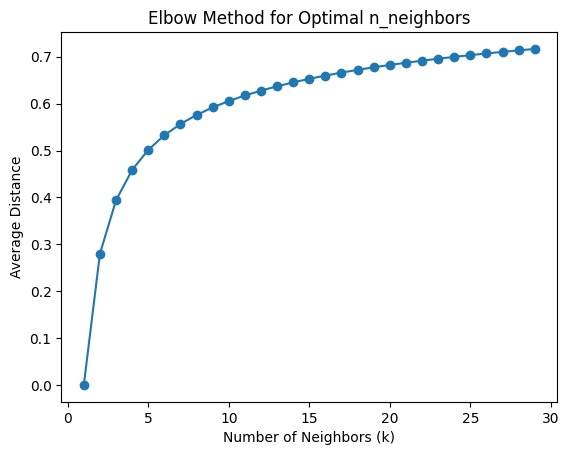

Optimal value for n_neighbors: 4


In [47]:
# Range of k values to test
k_values = range(1, 30)

# List to store average distances
avg_distances = []

for k in k_values:
    # Fit the model with the current value of k
    model = NearestNeighbors(n_neighbors=k, algorithm='brute', metric='cosine')
    model.fit(recommender.interaction_matrix)

    # Find distances and indices of k nearest neighbors
    distances, _ = model.kneighbors(recommender.interaction_matrix)

    # Calculate average distance
    avg_distance = distances.mean()
    avg_distances.append(avg_distance)

# Calculate differences between consecutive elements in avg_distances
differences = np.diff(avg_distances)

# Find the point where the rate of decrease slows down
elbow_index = np.argmax(differences < 0.05)  # Adjust the threshold as needed

# Get the optimal k value
optimal_k = k_values[elbow_index]

# Plot the elbow curve
plt.plot(k_values, avg_distances, marker='o')
plt.title('Elbow Method for Optimal n_neighbors')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Average Distance')
plt.show()

print(f'Optimal value for n_neighbors: {optimal_k}')


## Item-Based Colaborative filtering

In [51]:
# user_based_cf = CF(Y_data, k = 5, uuCF = 1)
# user_based_cf.fit()

recommender.create_model(k=optimal_k)
user_id='ur3032446'

# Check if there are any rows with the specified user_id
matching_rows = df[df.user_id == user_id]

if not matching_rows.empty:
    # If there are matching rows, retrieve the user_id_number
    user_id_number =matching_rows.values[0][3]
    movies_rated=recommender.get_rated_movies(user_id_number)
    pred_rating = recommender.calculate_score(user_id_number)
else:
    print(f"No rows found for user_id: {user_id}")
print(pred_rating)

success
Index([ 1099,  1105,  1115,  1870,  3048,  4412,  4564,  4909,  5031,  6068,
        7301,  9394, 10732, 10929, 11215, 11304, 11599, 12094, 12778, 13230,
       13388, 13515, 13799, 13845, 16332, 16682, 16848, 17473, 17906, 19472,
       21362, 21516, 24078],
      dtype='int64')
1099      7.0
1105      4.0
1115      4.0
1870      7.0
3048      8.0
4412      4.0
4564      7.0
4909     10.0
5031      7.0
6068      1.0
7301      7.0
9394     10.0
10732    10.0
10929     7.0
11215    10.0
11304     8.0
11599     3.0
12094     7.0
12778     7.0
13230    10.0
13388     1.0
13515    10.0
13799     3.0
13845     3.0
16332     8.0
16682     8.0
16848     1.0
17473    10.0
17906     7.0
19472    10.0
21362     7.0
21516    10.0
24078    10.0
dtype: float64


## Convert movie_id_number to movie title

In [52]:
movie_id_convert =df[['movie_id','movie_id_number']]
movie_id_convert= movie_id_convert.drop_duplicates()
movie_title = movies_df[['movie_id','title']]
movie_title_convert = pd.merge(movie_id_convert,movie_title)
movie_title_convert.head(10)

,movie_id,movie_id_number,title
0,tt0377092,11304,Mean Girls
1,tt6710474,26424,Everything Everywhere All at Once
2,tt11127680,15241,Boiling Point
3,tt0095444,3766,Killer Klowns from Outer Space
4,tt15474916,18374,Smile
5,tt0477348,12966,No Country for Old Men
6,tt0091251,3448,Come and See
7,tt0083929,2908,Fast Times at Ridgemont High
8,tt0114814,5126,The Usual Suspects
9,tt0093177,3584,Hellraiser


## Print recommendations

In [53]:
print("List of recommendations for user {}".format(user_id))
pred_rating.sort_values(inplace=True,ascending=False)
pred_rating_df = pd.DataFrame(pred_rating).reset_index()
pred_rating_df.columns = ['movie_id_number', 'predicted_rating']
final_pred_df = pd.merge(pred_rating_df,movie_id_convert)
final_pred_df = pd.merge(final_pred_df,movies_df)
final_pred_df = final_pred_df[['movie_id','title','predicted_rating']]
final_pred_df.head(10)

List of recommendations for user ur3032446


,movie_id,title,predicted_rating
0,tt4230204,I Capuleti e i Montecchi,10.0
1,tt0276124,Falstaff,10.0
2,tt2391038,Looking Is the Original Sin,10.0
3,tt1795368,National Theatre Live: Fela!,10.0
4,tt0371977,Espelho d'Água: Uma Viagem no Rio São Francisco,10.0
5,tt1412593,Chepachet,10.0
6,tt0111517,Turn of the Blade,10.0
7,tt0495033,Gatão de Meia Idade,10.0
8,tt0343135,Along Came Polly,10.0
9,tt0808266,Fica Comigo Esta Noite,10.0
